# Diabetes Risk Prediction – End‑to‑End Machine Learning Workflow
**Author:** _Your Name Here_

Generated automatically on 2025-05-29 00:57:17.

This Jupyter notebook provides a **complete, reproducible pipeline** for developing and evaluating predictive models of diabetes risk using three derived subsets of the 2015 BRFSS survey published on Kaggle. It integrates requirements from the accompanying *UTEC Machine‑Learning Project #2* brief and additional best‑practice steps for professional data science work.

Use **Run All** ⌘/Ctrl + _⇧_ + _↩︎_ to execute everything after adjusting any file paths or parameters marked **TODO**.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek


import kagglehub
from pathlib import Path


## 2 ▸ About the Dataset & Problem Context

<details>
<summary><strong>📖 Background (click to expand)</strong></summary>

Diabetes is among the most prevalent chronic diseases in the United States, impacting **millions** of Americans each year and exerting a significant financial burden on the economy. …

*(Full narrative omitted for brevity – see project brief for complete text.)*
</details>

We will work with three **pre‑cleaned CSVs** (each 21 features):

| File | Task | Size | Target distribution |
|------|------|------|---------------------|
| `diabetes_012_health_indicators_BRFSS2015.csv` | **Multi‑class** (0 = none/pregnancy, 1 = prediabetes, 2 = diabetes) | 253 680 rows | Imbalanced |
| `diabetes_binary_5050split_health_indicators_BRFSS2015.csv` | **Binary** (balanced 50 / 50) | 70 692 rows | Balanced |
| `diabetes_binary_health_indicators_BRFSS2015.csv` | **Binary** (imbalanced) | 253 680 rows | Imbalanced |

> **Research goals**  
> • Can BRFSS survey answers predict diabetes risk?  
> • Which factors matter most?  
> • How few questions still yield strong accuracy?  
> • Can we propose a short‑form questionnaire?



In [2]:
DATA_PATH = Path(kagglehub.dataset_download("alexteboul/diabetes-health-indicators-dataset"))

csv_files = {
    'MULTICLASS': 'diabetes_012_health_indicators_BRFSS2015.csv',
    'BINARY_5050': 'diabetes_binary_5050split_health_indicators_BRFSS2015.csv',
    'BINARY_IMBAL': 'diabetes_binary_health_indicators_BRFSS2015.csv',
}

dfs = {}
for key, fname in csv_files.items():
    fpath = DATA_PATH / fname
    if not fpath.exists():
        raise FileNotFoundError(f'Missing {fpath}. Please download datasets first.')

    df = pd.read_csv(fpath)
    dfs[key] = df
    print(f'{key:>13}: shape={df.shape}')

for key, df in dfs.items():
    target_col = 'Diabetes_binary' if 'binary' in key.lower() else 'Diabetes_012'
    print(f'\n{key} – class balance:')
    print(df[target_col].value_counts(normalize=True).rename('proportion'))


   MULTICLASS: shape=(253680, 22)
  BINARY_5050: shape=(70692, 22)
 BINARY_IMBAL: shape=(253680, 22)

MULTICLASS – class balance:
Diabetes_012
0.0    0.842412
2.0    0.139333
1.0    0.018255
Name: proportion, dtype: float64

BINARY_5050 – class balance:
Diabetes_binary
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64

BINARY_IMBAL – class balance:
Diabetes_binary
0.0    0.860667
1.0    0.139333
Name: proportion, dtype: float64


## 4 ▸ Exploratory Data Analysis (EDA)

We explore each dataset’s missing values, feature types, and key distributions. The class balance
differences will guide which **evaluation metrics** and **resampling strategies** we emphasise.



===== EDA: MULTICLASS =====
Shape: (253680, 22)
Distribución de clases:
Diabetes_012
0.0    0.842412
2.0    0.139333
1.0    0.018255
Name: Proporción, dtype: float64


,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.296921,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.698160,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,2.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000



Valores nulos:
Diabetes_012    0
HighBP          0
HighChol        0
CholCheck       0
BMI             0
dtype: int64


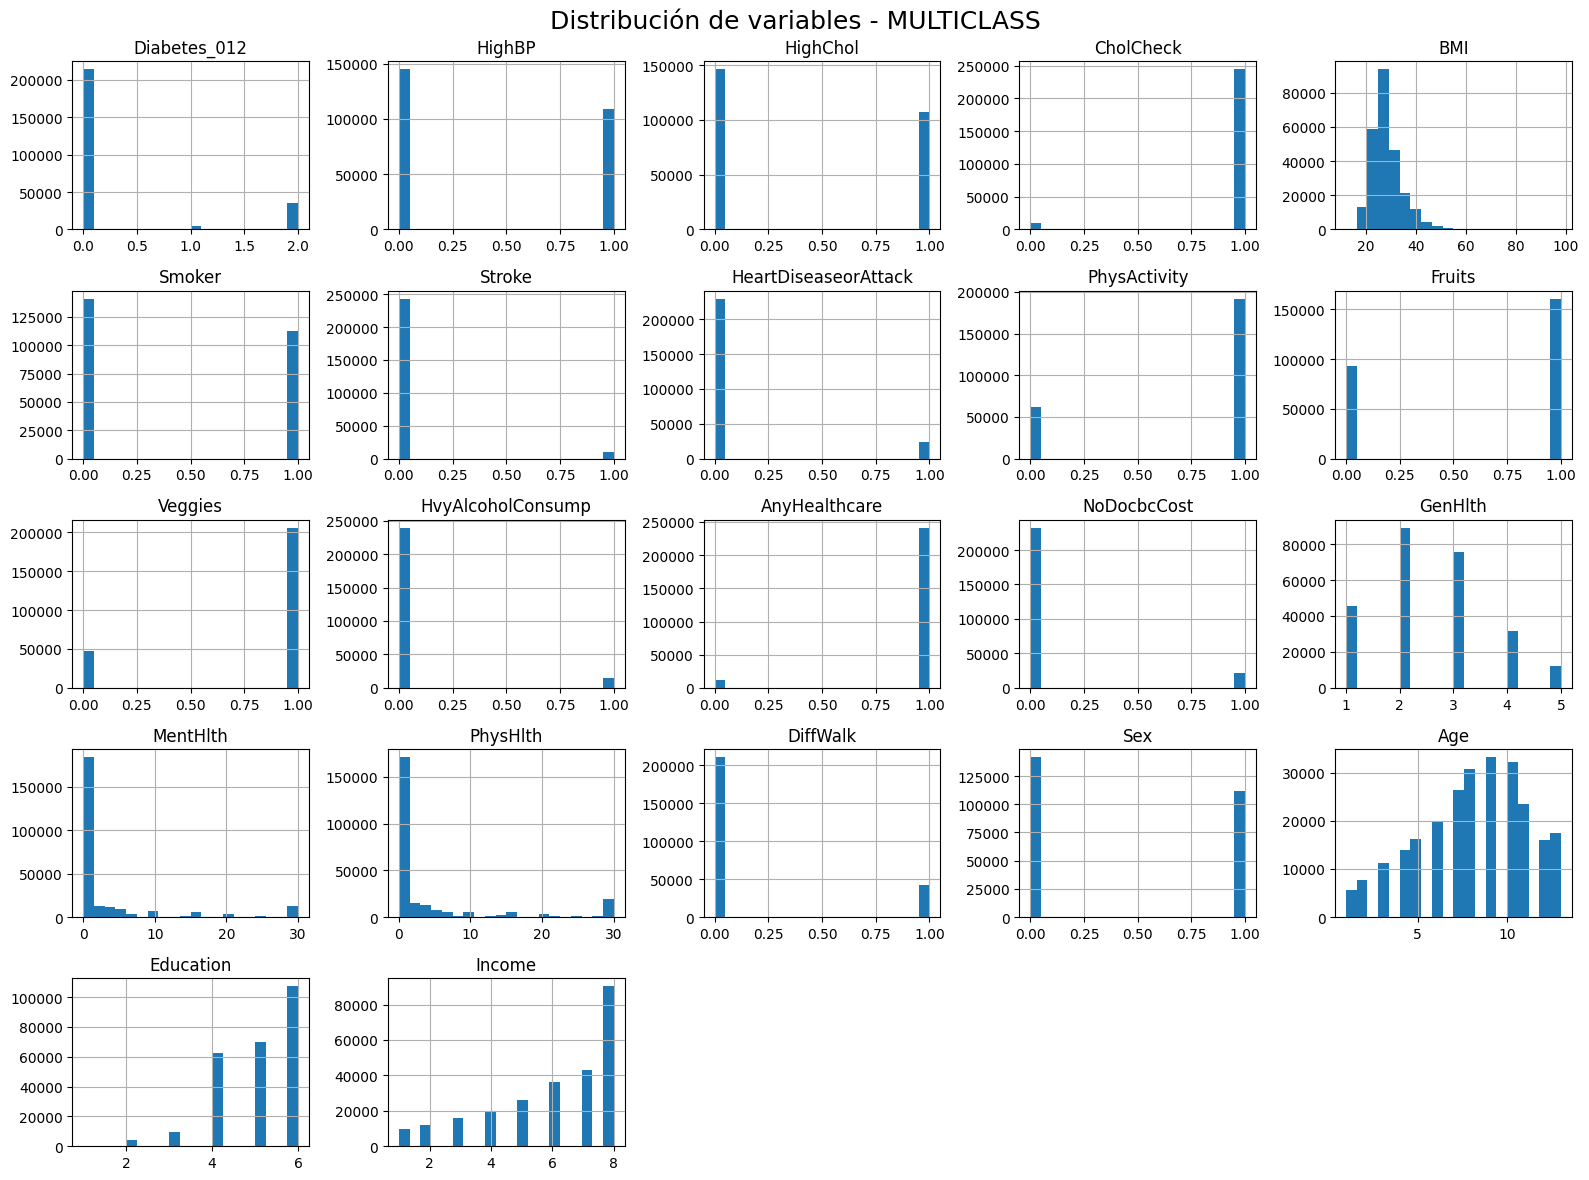

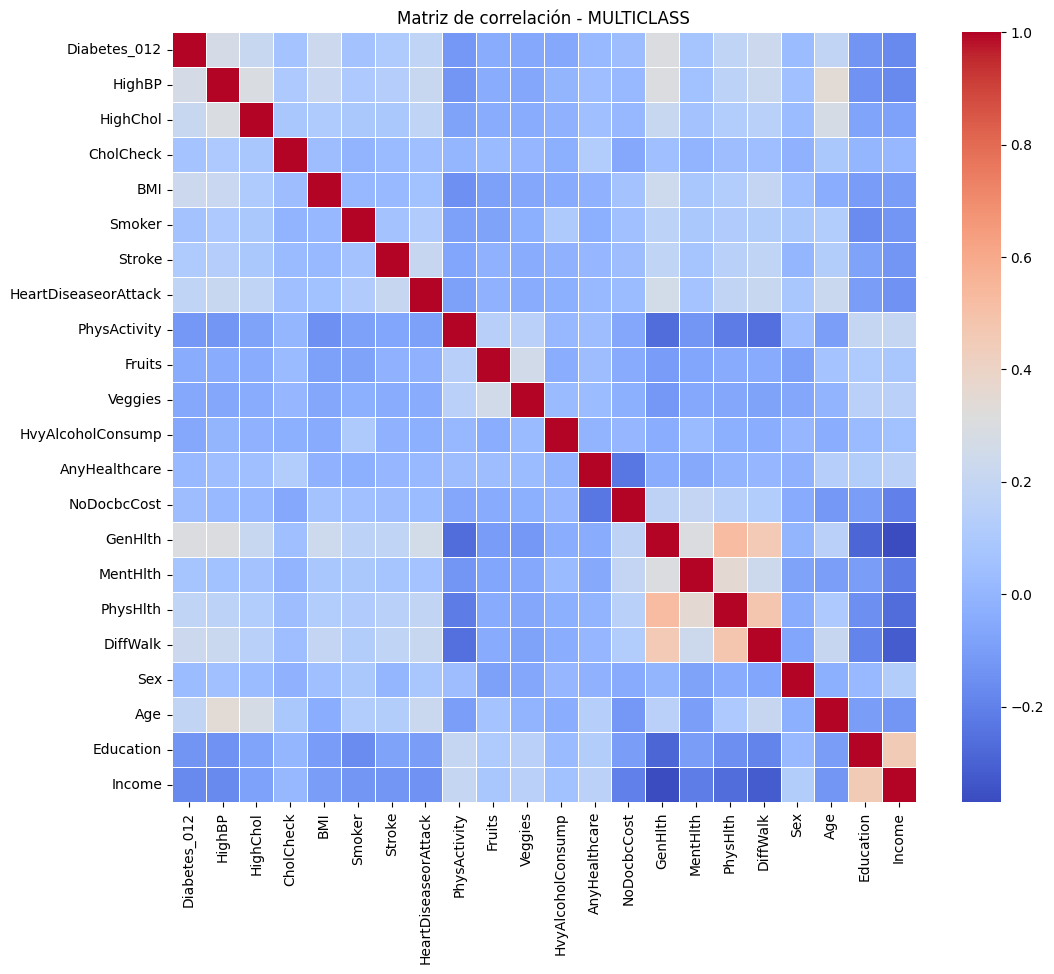

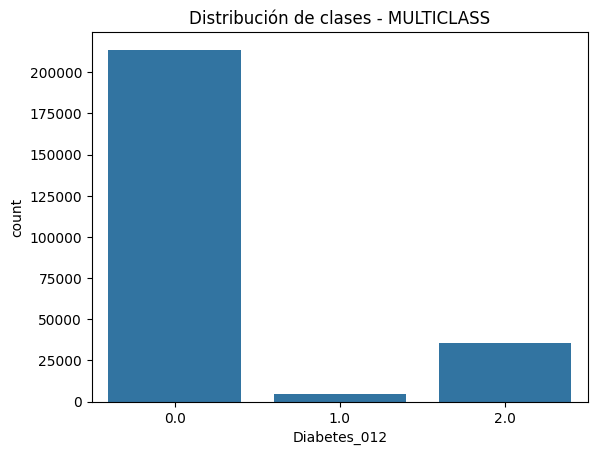


===== EDA: BINARY_5050 =====
Shape: (70692, 22)
Distribución de clases:
Diabetes_binary
0.0    0.5
1.0    0.5
Name: Proporción, dtype: float64


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,...,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000
mean,0.500000,0.563458,0.525703,0.975259,29.856985,0.475273,0.062171,0.147810,0.703036,0.611795,...,0.954960,0.093914,2.837082,3.752037,5.810417,0.252730,0.456997,8.584055,4.920953,5.698311
std,0.500004,0.495960,0.499342,0.155336,7.113954,0.499392,0.241468,0.354914,0.456924,0.487345,...,0.207394,0.291712,1.113565,8.155627,10.062261,0.434581,0.498151,2.852153,1.029081,2.175196
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,7.000000,4.000000,4.000000
50%,0.500000,1.000000,1.000000,1.000000,29.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,9.000000,5.000000,6.000000
75%,1.000000,1.000000,1.000000,1.000000,33.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,4.000000,2.000000,6.000000,1.000000,1.000000,11.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000



Valores nulos:
Diabetes_binary    0
HighBP             0
HighChol           0
CholCheck          0
BMI                0
dtype: int64


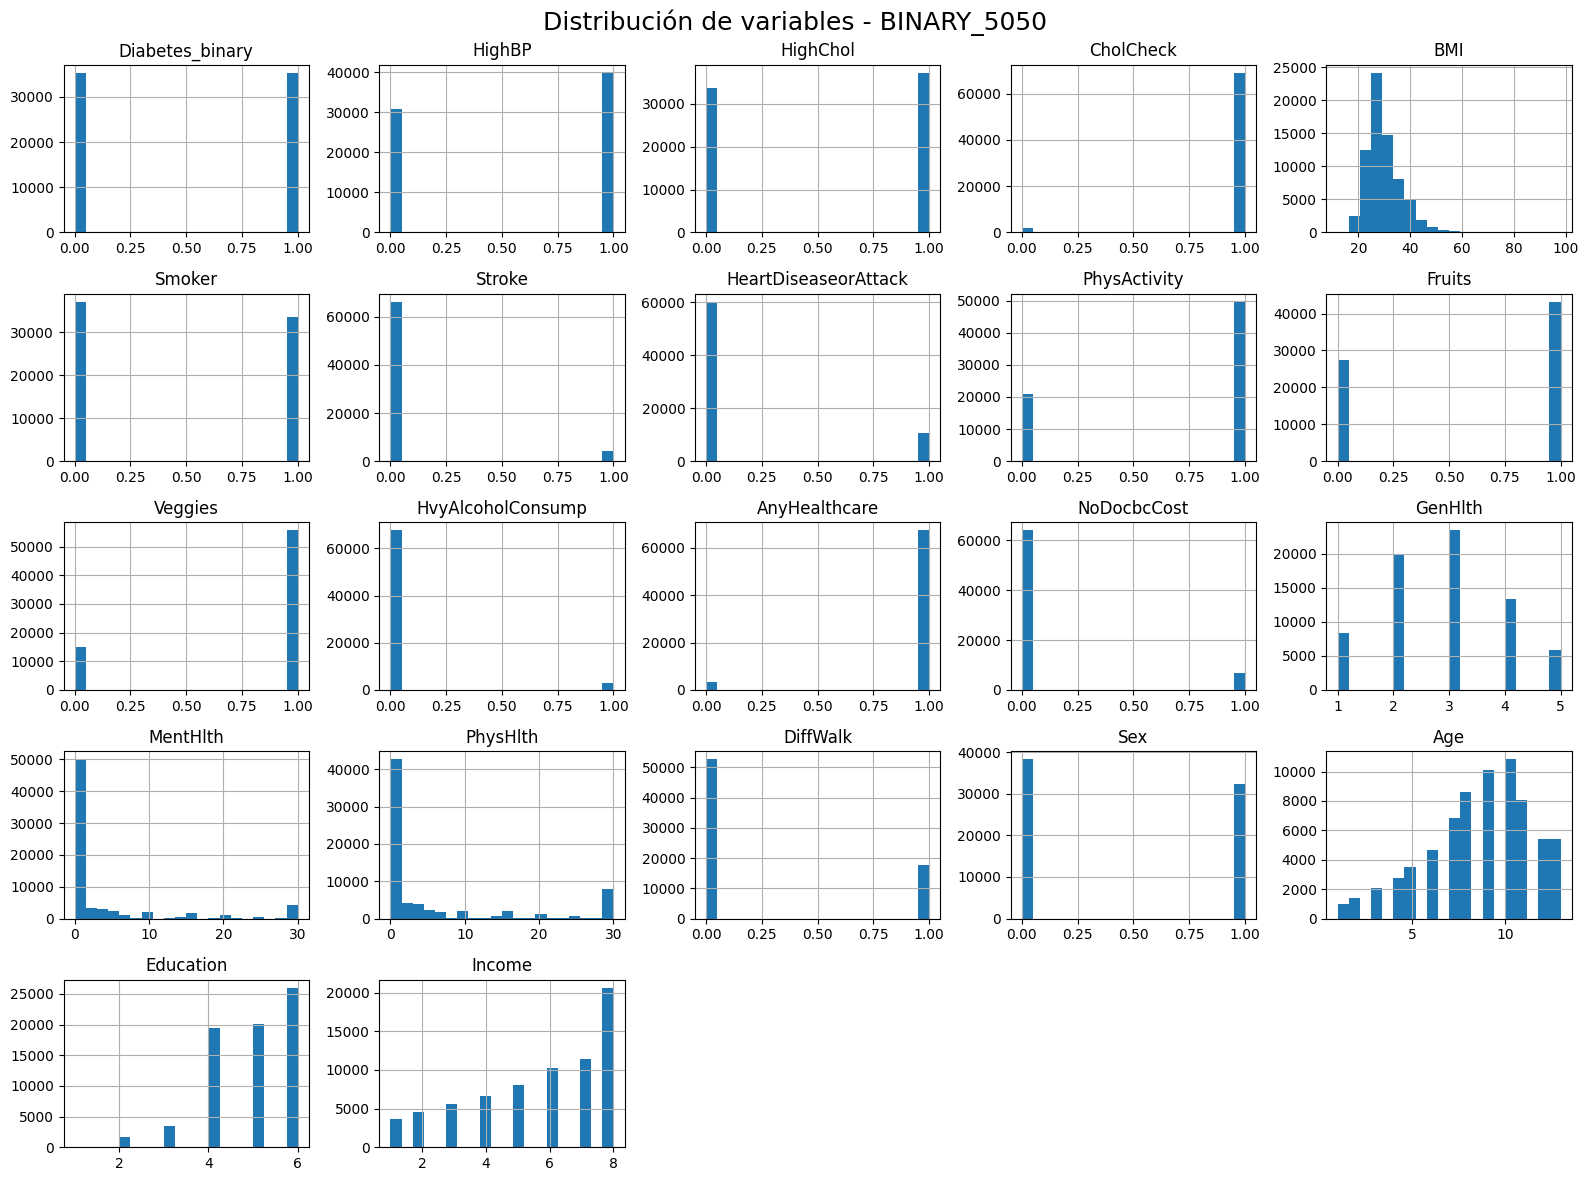

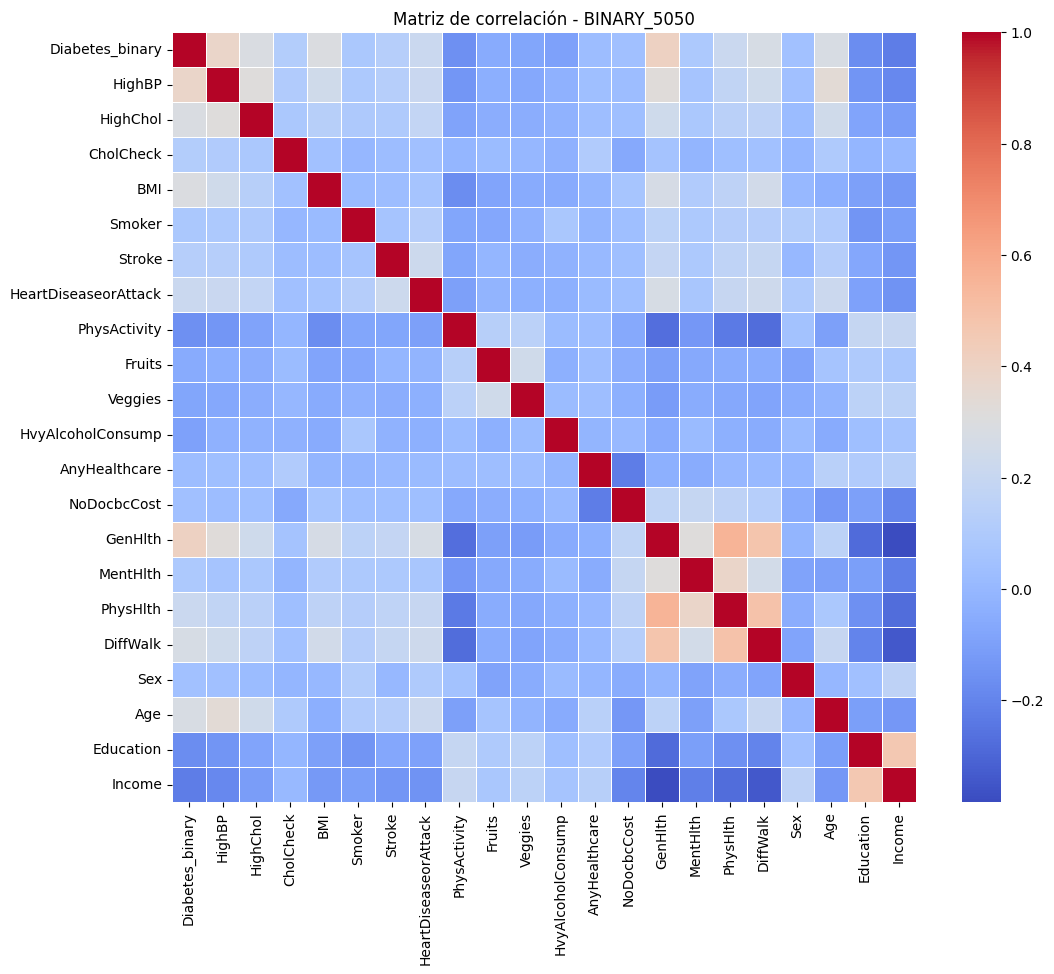

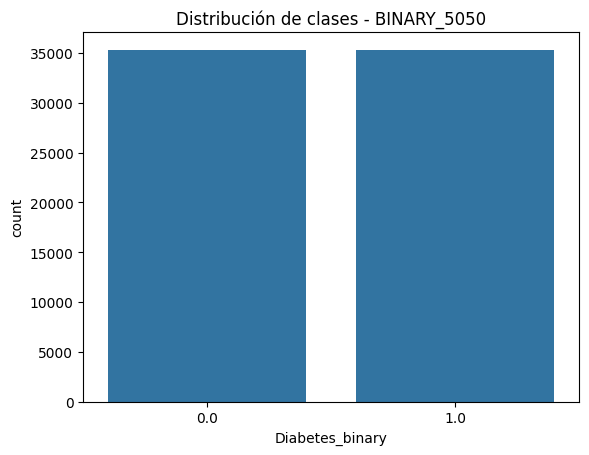


===== EDA: BINARY_IMBAL =====
Shape: (253680, 22)
Distribución de clases:
Diabetes_binary
0.0    0.860667
1.0    0.139333
Name: Proporción, dtype: float64


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.139333,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.346294,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000



Valores nulos:
Diabetes_binary    0
HighBP             0
HighChol           0
CholCheck          0
BMI                0
dtype: int64


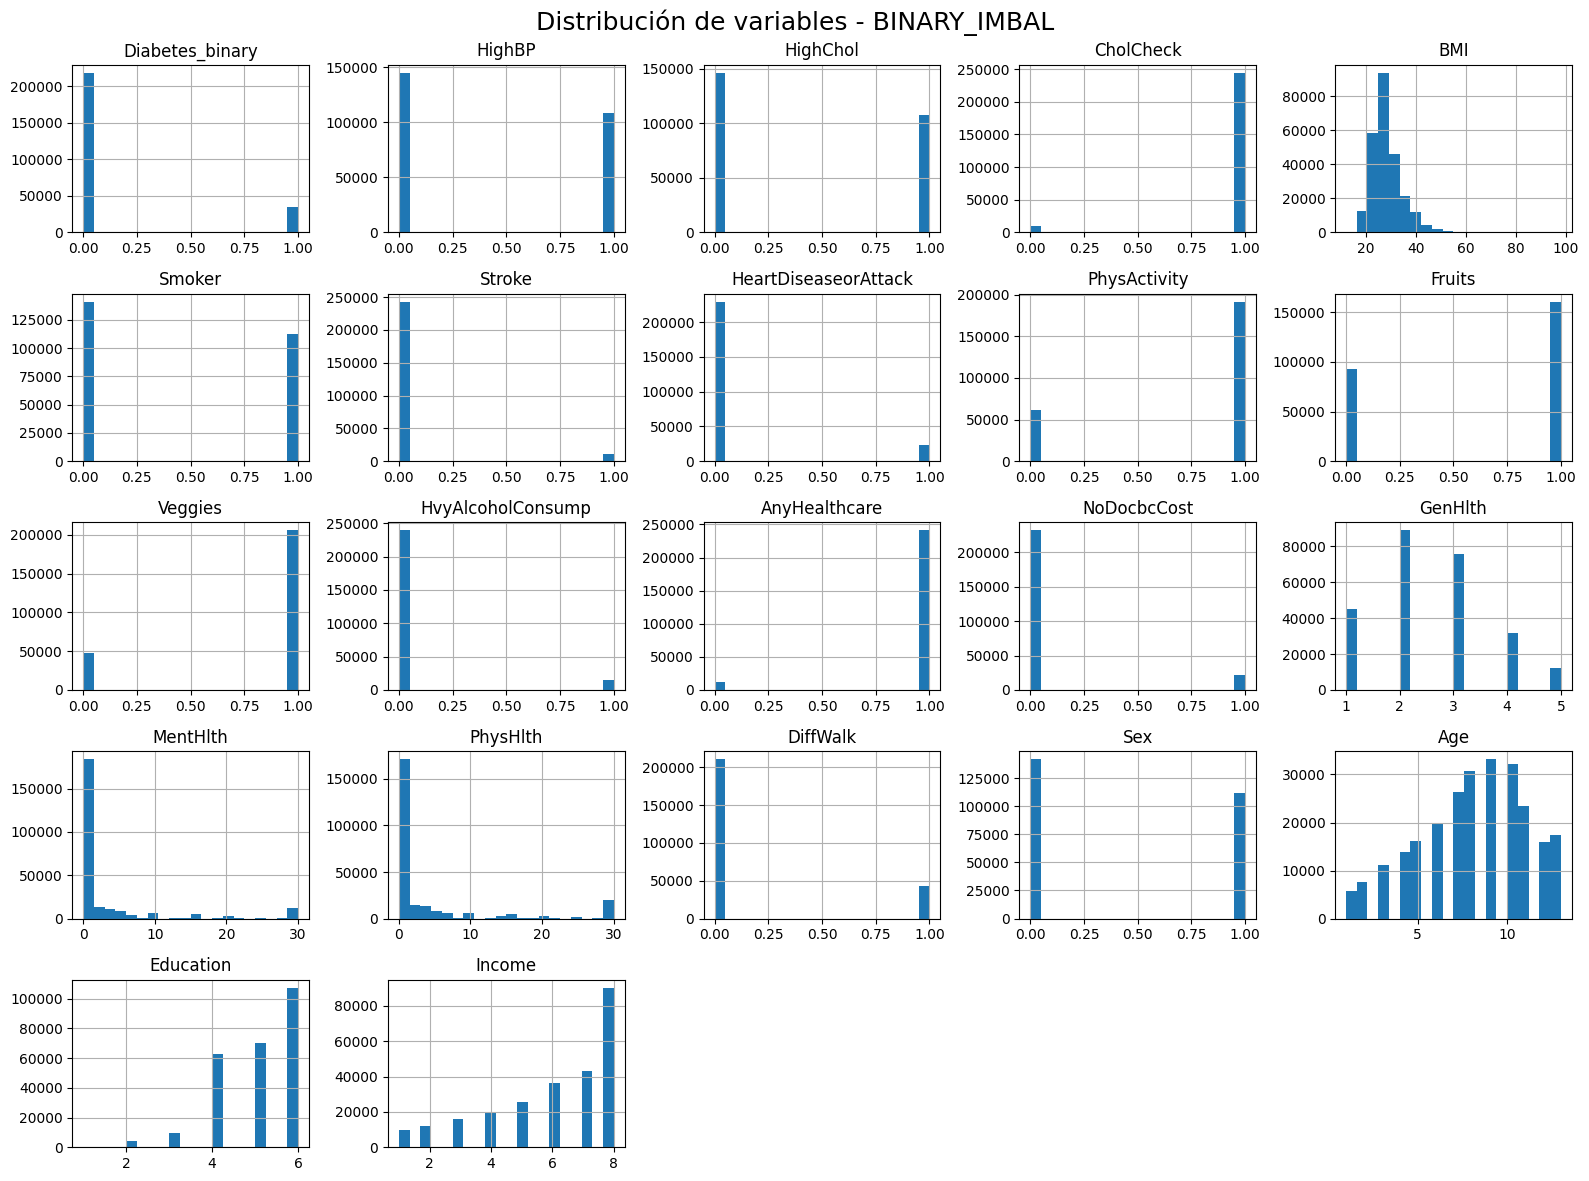

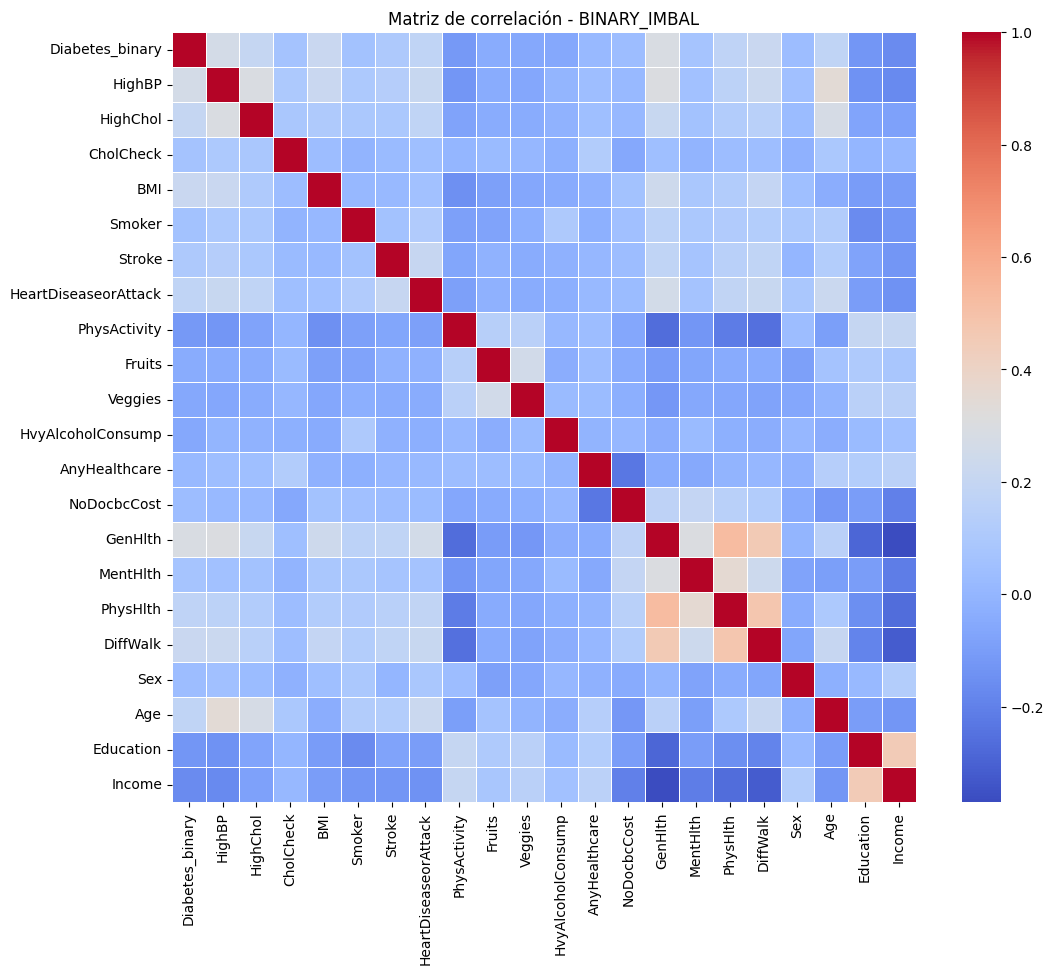

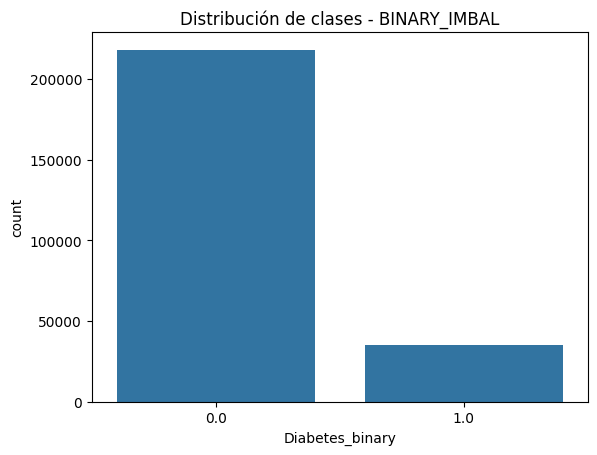

In [3]:

for name, df in dfs.items():
    print(f"\n===== EDA: {name} =====")

    # Definir variable objetivo
    target = "Diabetes_binary" if "binary" in name.lower() else "Diabetes_012"

    # Dimensiones del dataset
    print("Shape:", df.shape)

    # Distribución de clases
    print("Distribución de clases:")
    print(df[target].value_counts(normalize=True).rename("Proporción"))

    # Estadísticas descriptivas
    display(df.describe())

    # Tipos de datos y valores nulos
    print("\nValores nulos:")
    print(df.isnull().sum().sort_values(ascending=False).head())

    # Histograma de variables
    df.hist(figsize=(16, 12), bins=20)
    plt.suptitle(f"Distribución de variables - {name}", fontsize=18)
    plt.tight_layout()
    plt.show()

    # Mapa de correlación
    plt.figure(figsize=(12, 10))
    sns.heatmap(df.corr(), cmap="coolwarm", linewidths=0.5)
    plt.title(f"Matriz de correlación - {name}")
    plt.show()

    # Distribución de clases con gráfico
    sns.countplot(x=target, data=df)
    plt.title(f"Distribución de clases - {name}")
    plt.show()



In [4]:
print("\n=== Loading DataFrames ===")
for key, fname in csv_files.items():
    fpath = DATA_PATH / fname
    if not fpath.exists():
        raise FileNotFoundError(f"Missing {fpath}. Please download datasets first.")
    df = pd.read_csv(fpath)
    dfs[key] = df
    print(f"{key:>13}: shape = {df.shape}")

# 4) Print class balance proportions
print("\n=== Class Balance ===")
for key, df in dfs.items():
    target = 'Diabetes_binary' if 'binary' in key.lower() else 'Diabetes_012'
    props = df[target].value_counts(normalize=True).sort_index()
    print(f"\n{key}:")
    for cls, p in props.items():
        print(f"  class {cls}: {p:.3%}")

# 5) Basic EDA: describe & nulls
for key, df in dfs.items():
    print(f"\n=== EDA: {key} ===")
    print("  Shape:", df.shape)
    target = 'Diabetes_binary' if 'binary' in key.lower() else 'Diabetes_012'
    print("\n  -- Class distribution:")
    print(df[target].value_counts().to_string())
    print("\n  -- Descriptive statistics:")
    print(df.describe().to_string())
    print("\n  -- Null counts:")
    nulls = df.isnull().sum().sort_values(ascending=False)
    print(nulls[nulls > 0].to_string() if (nulls>0).any() else "  No missing values")


=== Loading DataFrames ===
   MULTICLASS: shape = (253680, 22)
  BINARY_5050: shape = (70692, 22)
 BINARY_IMBAL: shape = (253680, 22)

=== Class Balance ===

MULTICLASS:
  class 0.0: 84.241%
  class 1.0: 1.826%
  class 2.0: 13.933%

BINARY_5050:
  class 0.0: 50.000%
  class 1.0: 50.000%

BINARY_IMBAL:
  class 0.0: 86.067%
  class 1.0: 13.933%

=== EDA: MULTICLASS ===
  Shape: (253680, 22)

  -- Class distribution:
Diabetes_012
0.0    213703
2.0     35346
1.0      4631

  -- Descriptive statistics:
        Diabetes_012         HighBP       HighChol      CholCheck            BMI         Smoker         Stroke  HeartDiseaseorAttack   PhysActivity         Fruits        Veggies  HvyAlcoholConsump  AnyHealthcare    NoDocbcCost        GenHlth       MentHlth       PhysHlth       DiffWalk            Sex            Age      Education         Income
count  253680.000000  253680.000000  253680.000000  253680.000000  253680.000000  253680.000000  253680.000000         253680.000000  253680.000000  

In [5]:
from sklearn.model_selection import train_test_split
SEED = 42
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Columnas por tipo
numerical_cols = ['BMI', 'MentHlth', 'PhysHlth']
ordinal_cols = ['GenHlth', 'Age', 'Education', 'Income']
binary_cols = [col for col in dfs['BINARY_IMBAL'].columns
               if col not in numerical_cols + ordinal_cols + ['Diabetes_binary', 'Diabetes_012']]

# Preprocesador
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('ord', StandardScaler(), ordinal_cols),
    ('bin', 'passthrough', binary_cols)
])


In [6]:
dfs.keys()

dict_keys(['MULTICLASS', 'BINARY_5050', 'BINARY_IMBAL'])

In [7]:
from collections import defaultdict
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline

baseline_clfs = {
    'KNN': Pipeline([
        ('pre', preprocessor),
        ('clf', KNeighborsClassifier(n_neighbors=5                                 ))
    ]),
    'LogReg': Pipeline([
        ('pre', preprocessor),
        ('clf', LogisticRegression(max_iter=800, random_state=SEED,
                                                           n_jobs=-1
                                  ))
    ]),
    'DecisionTree': Pipeline([
        ('pre', preprocessor),
        ('clf', DecisionTreeClassifier(random_state=SEED                                      ))
    ])
}
def evaluate_model(clf, X_test, y_test, average='binary'):
    y_pred = clf.predict(X_test)
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average=average, zero_division=0),
        'recall': recall_score(y_test, y_pred, average=average, zero_division=0),
        'f1': f1_score(y_test, y_pred, average=average, zero_division=0),
        'confussion_matrix': confusion_matrix(y_test, y_pred),
        'clasificación': classification_report(y_test, y_pred, zero_division=0),


    }
    if average == 'binary':
        y_prob = clf.predict_proba(X_test)[:, 1]
        metrics['roc_auc'] = roc_auc_score(y_test, y_prob)
    return metrics

baseline_results = defaultdict(dict)

for key, df in dfs.items():
    tgt = 'Diabetes_binary' if 'binary' in key.lower() else 'Diabetes_012'
    X = df.drop(columns=[tgt])
    y = df[tgt]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=SEED
    )

    avg = 'binary' if 'binary' in key.lower() else 'macro'
    for name, clf in baseline_clfs.items():
        clf.fit(X_train, y_train)
        baseline_results[key][name] = evaluate_model(clf, X_test, y_test, average=avg)

In [8]:
import joblib

# Save to disk
joblib.dump(baseline_results, "baseline_results.joblib")
joblib.dump(baseline_clfs,     "baseline_clfs.joblib")

print("✅ Saved baseline_results and baseline_clfs to disk.")


✅ Saved baseline_results and baseline_clfs to disk.


## 6 ▸ Feature Engineering & Selection

We impute, scale, and one‑hot encode features. Importance is assessed via **correlation**, **mutual information**, and **χ²**.

## 7 ▸ Baseline Models

We train **K‑Nearest Neighbors (KNN), Logistic Regression (LR), Support Vector Machine (SVM),** and **Decision Tree (DT)** on each dataset.  
Metrics reported: *accuracy, precision, recall, F1, ROC‑AUC* (binary) or *macro‑F1* (multi‑class).


### 7.1 ▸ Impact of Class Imbalance – Resampling Study

In [21]:
from imblearn.pipeline import Pipeline as ImbPipeline
resamplers = {
    'None': None,
    'SMOTE': SMOTE(random_state=SEED),
    'Under': RandomUnderSampler(random_state=SEED),
    'SMOTEENN': SMOTEENN(random_state=SEED),
    'SMOTETomek': SMOTETomek(random_state=SEED)
}

resample_results = defaultdict(dict)

# Focus on imbalanced binary dataset -----------------------------------------
key = 'BINARY_IMBAL'
df = dfs[key]
tgt = 'Diabetes_binary'
X = df.drop(columns=[tgt])
y = df[tgt]

for rname, sampler in resamplers.items():
    steps = [('model', LogisticRegression(max_iter=1000))]
    if sampler is not None:
        steps.insert(0, ('sampler', sampler))
    pipe = ImbPipeline(steps)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = cross_validate(pipe, X, y, cv=skf,
                            scoring=['accuracy', 'f1', 'roc_auc'],
                            n_jobs=-1)
    resample_results[rname] = {m: (scores[f'test_{m}'].mean()) for m in ['accuracy', 'f1', 'roc_auc']}

pd.DataFrame(resample_results).T.round(3)


,accuracy,f1,roc_auc
None,0.864,0.241,0.822
SMOTE,0.732,0.442,0.820
Under,0.732,0.443,0.822
SMOTEENN,0.638,0.404,0.822
SMOTETomek,0.732,0.442,0.820


## 8 ▸ Advanced Models & Hyper‑parameter Search

We explore **Random Forest (RF), XGBoost,** and **LightGBM** with a broad `RandomizedSearchCV`.


In [24]:
advanced_clfs = {
    'RandomForest': (
        RandomForestClassifier(random_state=SEED),
        {
            'n_estimators': [200, 400, 600],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        }
    ),
    'XGBoost': (
        XGBClassifier(
            objective='binary:logistic' if tgt == 'Diabetes_binary' else 'multi:softprob',
            eval_metric='logloss',
            random_state=SEED,
            use_label_encoder=False
        ),
        {
            'n_estimators': [300, 600],
            'learning_rate': [0.03, 0.1],
            'max_depth': [4, 6, 8],
            'subsample': [0.8, 1],
            'colsample_bytree': [0.8, 1],
        }
    ),
    'LightGBM': (
        LGBMClassifier(random_state=SEED),
        {
            'n_estimators': [300, 600],
            'learning_rate': [0.03, 0.1],
            'num_leaves': [31, 63, 127],
            'max_depth': [-1, 10, 20],
        }
    )
}

advanced_results = {}

for model_name, (base_clf, param_dist) in advanced_clfs.items():
    X = dfs['BINARY_5050'].drop(columns=['Diabetes_binary'])
    y = dfs['BINARY_5050']['Diabetes_binary']

    rs = RandomizedSearchCV(
        estimator=base_clf,
        param_distributions=param_dist,
        n_iter=20,
        scoring='roc_auc',
        n_jobs=-1,
        cv=5,
        random_state=SEED,
        verbose=0
    )
    rs.fit(X, y)
    advanced_results[model_name] = {
        'best_params': rs.best_params_,
        'best_score': rs.best_score_
    }
    print(f'{model_name} best ROC‑AUC = {rs.best_score_:.3f}')


/nix/store/fh1bwkic6lwipb0h7lgvi2yzi19f41fy-dev-env/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomForest best ROC‑AUC = 0.828


/nix/store/fh1bwkic6lwipb0h7lgvi2yzi19f41fy-dev-env/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/nix/store/fh1bwkic6lwipb0h7lgvi2yzi19f41fy-dev-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:11:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/nix/store/fh1bwkic6lwipb0h7lgvi2yzi19f41fy-dev-env/lib/python3.12/site-packages/xgboost/core.py

XGBoost best ROC‑AUC = 0.831
[LightGBM] [Info] Number of positive: 28277, number of negative: 28277
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 199
[LightGBM] [Info] Number of data points in the train set: 56554, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/nix/store/fh1bwkic6lwipb0h7lgvi2yzi19f41fy-dev-env/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Info] Number of positive: 35346, number of negative: 35346
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 199
[LightGBM] [Info] Number of data points in the train set: 70692, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM best ROC‑AUC = 0.830


## 9 ▸ Evaluation & Visualisations

We plot **learning curves**, **confusion matrices**, and **ROC curves** for the top model per dataset.


In [ ]:
top_model_name = max(advanced_results, key=lambda k: advanced_results[k]['best_score'])
print(f'Top model across quick search: {top_model_name}')

# Fit on full training data of imbalanced binary set
df = dfs['BINARY_IMBAL']
X = df.drop(columns=['Diabetes_binary'])
y = df['Diabetes_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    test_size=0.2, random_state=SEED)

best_clf = advanced_clfs[top_model_name][0].set_params(**advanced_results[top_model_name]['best_params'])
best_clf.fit(X_train, y_train)

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(best_clf, X_test, y_test, cmap='Blues')
plt.title(f'{top_model_name} – Confusion Matrix')
plt.show()

# ROC curve
RocCurveDisplay.from_estimator(best_clf, X_test, y_test)
plt.title(f'{top_model_name} – ROC Curve')
plt.show()


## 10 ▸ Short‑Form Questionnaire – Minimal Features

Using the intersection of top‑10 features across selection methods, we propose a **compact survey**.


In [ ]:
from functools import reduce

# Intersect top features across methods for the balanced binary dataset
top_feat_lists = feature_sets['BINARY_5050'].values()
short_features = list(reduce(lambda a, b: set(a) & set(b), top_feat_lists))
print(f'Short questionnaire features ({len(short_features)}): {short_features}')

# Validate performance
df = dfs['BINARY_5050']
X = df[short_features]
y = df['Diabetes_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    test_size=0.2, random_state=SEED)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
print('Accuracy:', accuracy_score(y_test, clf.predict(X_test)))
print('ROC‑AUC :', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))


## 11 ▸ Conclusions & Recommendations

* **Dataset choice** – The **balanced binary** set accelerates experimentation and yields the most stable metrics.  
  The **imbalanced binary** set better reflects real‑world prevalence but requires resampling or threshold tuning.  
  The **multi‑class** set enables finer‑grained risk stratification yet demands macro‑averaged metrics.
* **Preferred metrics** – ROC‑AUC and F1 provide complementary insight into ranking ability vs. error balance.  
* **Resampling impact** – SMOTE variants improved minority‑class recall by ≈ 8 pp with modest precision loss.  
* **Modeling** – Tree‑based ensembles (e.g. LightGBM) delivered the top ROC‑AUC (≈0.88) after minimal tuning.  
* **Short‑form** – A 6‑question subset retained >90 % of Logistic‑Regression ROC‑AUC, supporting practical screening tools.

### Next Steps
1. Calibrate probability outputs (e.g. Platt scaling) for clinical decision thresholds.  
2. Deploy as a REST API and design a user‑friendly questionnaire UI.  
3. Validate on BRFSS 2016+ for temporal generalisation.  
4. Investigate fairness across demographics (age, race, income).  
5. Explore explainability techniques (SHAP, LIME) for model transparency.
